In [1]:
from typing import List,Dict

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_service import get_index_daily, get_sales_depart_billboard
from scr import HMA,calc_netbuy,get_exchange_set
from scr.plotting import plot_indicator,plot_distribution,plot_qunatile_signal
from scr.tushare_api import TuShare

my_ts = TuShare()

# 数据准备

In [3]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2022-02-02')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

机构龙虎榜数据获取:   0%|          | 0/2207 [00:00<?, ?it/s]

2022-06-28 08:29:51,073 TuShare e:\WorkSpace\Quantitative-analysis\C-择时类\特征分布建模择时\scr\tushare_api.py:62 wrapper ERROR TuShare exec top_inst failed, args:(), kwargs:{'trade_date': '20160509'}, try again.
Traceback (most recent call last):
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 665, in urlopen
    httplib_response = self._make_request(
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "d:\anaconda3\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "d:\anaconda3\lib\http\client.py", line 331, in begin
    self.headers = self.msg = parse_headers(self.fp)
  File "d:\anaconda3\lib\http\client.py", line 216, in parse_headers
    line = fp.readline(_MAXLINE + 1)
  File "d:\anaconda3\li

2022-06-28 08:29:51,073 - TuShare - ERROR - TuShare exec top_inst failed, args:(), kwargs:{'trade_date': '20160509'}, try again.
Traceback (most recent call last):
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 665, in urlopen
    httplib_response = self._make_request(
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "d:\anaconda3\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "d:\anaconda3\lib\http\client.py", line 331, in begin
    self.headers = self.msg = parse_headers(self.fp)
  File "d:\anaconda3\lib\http\client.py", line 216, in parse_headers
    line = fp.readline(_MAXLINE + 1)
  File "d:\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
Con

In [2]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [3]:
# 获取沪深300数据
hs300:pd.DataFrame = get_index_daily(code='000300.SH',start_date = '20130101',end_date='20220222')
hs300.set_index('trade_date',inplace=True)

In [4]:
# 查看数据结构
hs300.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07


In [5]:
# 查看数据结构
billboard_df.head()

,trade_date,code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
0,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.0,1.24,-593187.06,0,连续三个交易日内，涨幅偏离值累计达20%的证券
264,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,1,换手率达20%的证券
263,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,0,换手率达20%的证券
262,2013-01-04,300262.SZ,中国银河证券股份有限公司厦门美湖路证券营业部,7913689.96,0.01,26770.0,2.75,-7886919.96,1,换手率达20%的证券
261,2013-01-04,300262.SZ,中信证券股份有限公司上海淮海中路证券营业部,4772872.77,1.53,4398000.0,1.66,-374872.77,0,换手率达20%的证券


## 席位分析

In [10]:
# 席位划分
exchange_set:Dict = get_exchange_set(billboard_df)

可以看到**机构席位**(图二):当相对净流入指标处于极值两端的时候,市场的未来期望收益率更高,即龙虎榜机构席位出现较大净流出或净流入后,后10日的沪深300指数对应为表现较好，而龙虎榜机构席位的净流入或净流出绝对值较低时，后10日的沪深300指数对应为表现较差。统计结果印证了机构龙虎榜影响下的有限注意力规律，即当机构席 位出现极端行为时很多的决策注意力被吸引而来，出现了较为明显的非线性交易规律， 整体的收益分布呈现出明显的V字型，即正收益来自于两端，负收益来自于中间。如果 择时因子与宽基未来收益显著正相关，且相关系数是 1，那么期望收益分布图则是一个 单调递增的形状。因此，期望收益分布图简单明了的表示择时因子与未来收益的非线性关系，而 IS_NetBuy_S 指标的期望收益分布图就是呈现出V型的非线性关系。

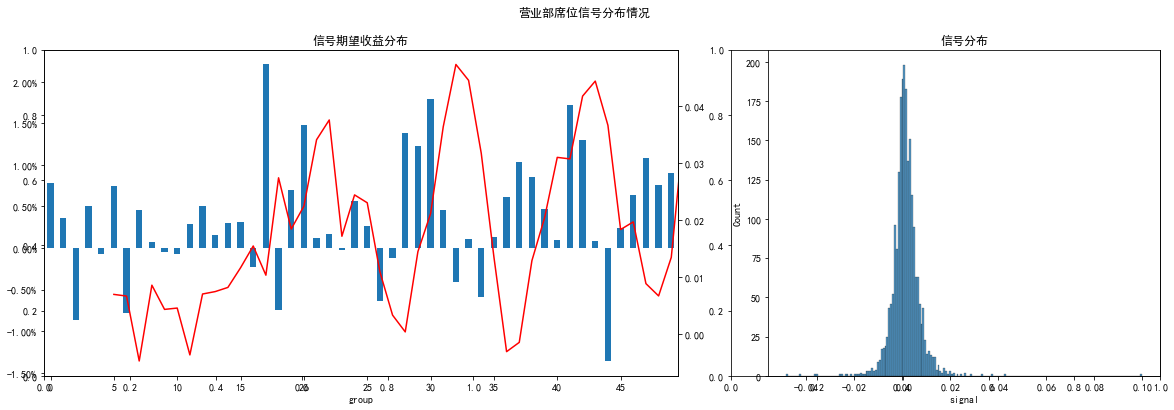

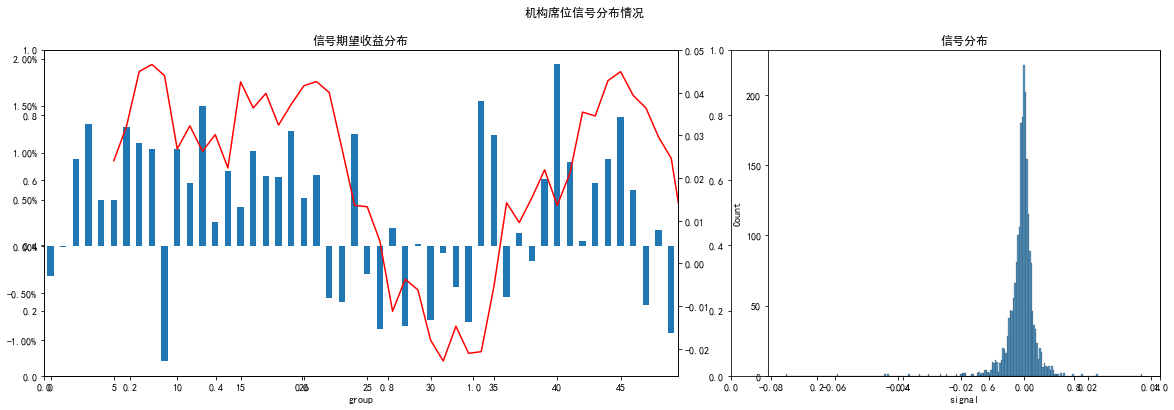

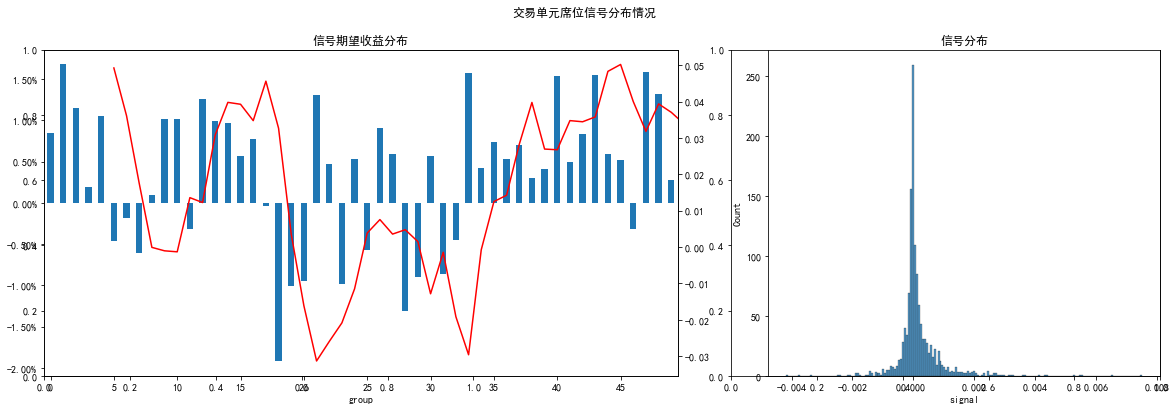

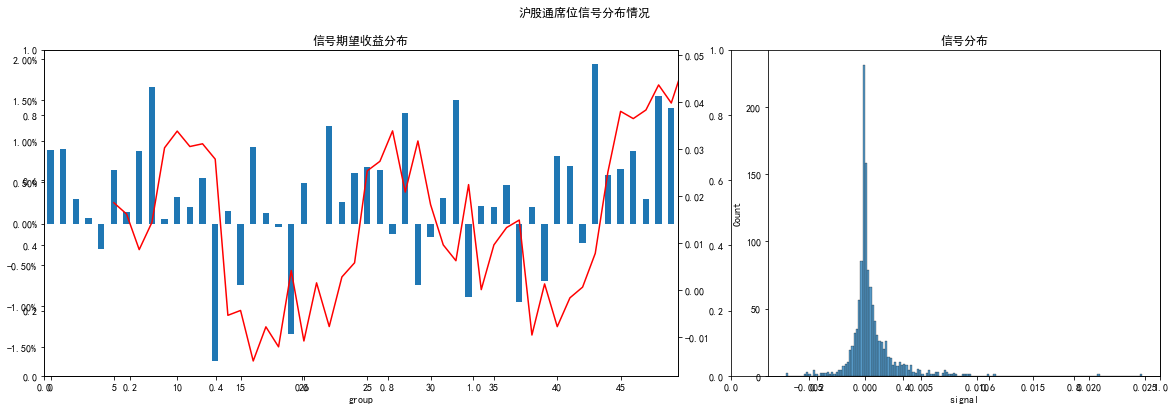

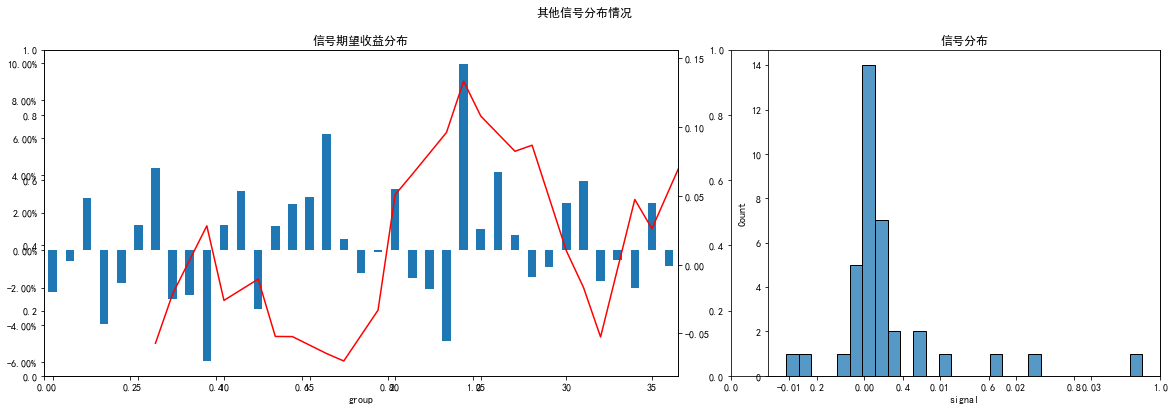

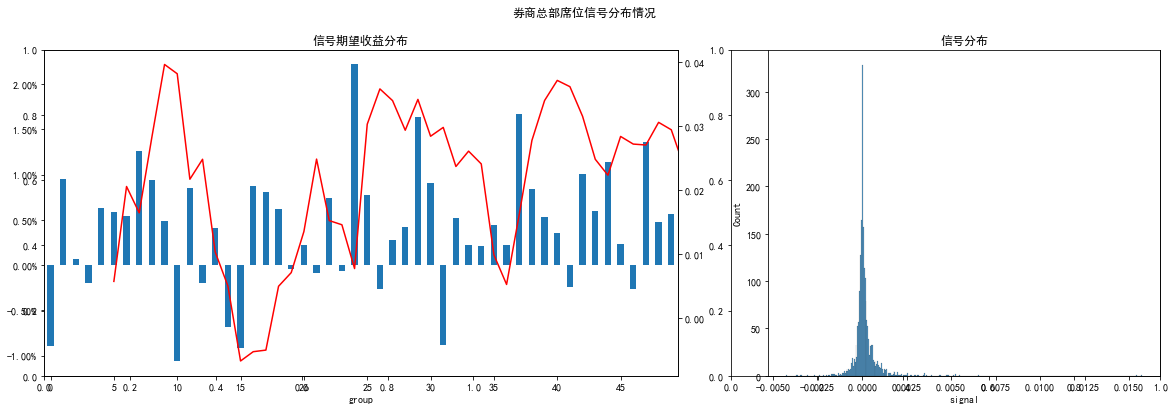

In [9]:
size:int = len(exchange_set)

for name,cond in exchange_set.items():
    
    is_netbuy_s:pd.Series = calc_netbuy(billboard_df[cond],hs300['amount'])
    plot_distribution(is_netbuy_s,hs300['close'],10,f'{name}信号分布情况')

# VBT回测

In [96]:
import vectorbt as vbt

In [125]:
# 计算HMA信号
is_netbuy_s_s: pd.Series = HMA(is_netbuy_s, 30)
is_netbuy_s_l: pd.Series = HMA(is_netbuy_s, 100)

to_buy1: pd.Series = (is_netbuy_s_s > is_netbuy_s_l) & (is_netbuy_s_s > 0) & (
    is_netbuy_s_l > 0)
to_buy2: pd.Series = (is_netbuy_s_s < is_netbuy_s_l) & (is_netbuy_s_s < 0) & (
    is_netbuy_s_l < 0)

# 注:信号滞后 不然会有未来
entries: pd.Series = (to_buy1 | to_buy2).vbt.signals.fshift()
exits: pd.Series = (~entries)

direction = ['longonly']
fees = 0.001
pf = vbt.Portfolio.from_signals(
    close=hs300['close'].reindex(is_netbuy_s_s.index),
    price=hs300['open'].reindex(is_netbuy_s_s.index),
    entries=entries,
    exits=exits,
    direction=direction,
    fees=fees,
    log=True)


In [126]:
pf.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2013-07-10,0.046184,2163.0980,0.099900,Buy
1,1,0,2013-07-18,0.046184,2272.9470,0.104973,Sell
2,2,0,2013-07-24,0.046492,2253.3760,0.104764,Buy
3,3,0,2013-08-08,0.046492,2277.2530,0.105874,Sell
4,4,0,2013-09-02,0.045545,2319.9570,0.105662,Buy
...,...,...,...,...,...,...,...
168,168,0,2021-11-02,0.058413,4886.1849,0.285414,Buy
169,169,0,2021-12-08,0.058413,4934.4056,0.288231,Sell
170,170,0,2022-01-07,0.059626,4824.3181,0.287655,Buy
171,171,0,2022-01-17,0.059626,4728.7595,0.281957,Sell


In [122]:
pf.plot(subplots=['drawdowns', 'underwater'])

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#9467bd'},
              'na…

In [123]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

# 回测

## 双均线策略

In [55]:
import datetime as dt

import backtrader as bt
from scr.bt_func import analysis_rets, analysis_trade, get_backtesting

In [83]:
class ma_cross(bt.Strategy):
    """策略逻辑:

    1.大幅相对净流入:IS_NetBuy_S_S>IS_NetBuy_S_L(短期均线大于长期均线)且短期均 线 IS_NetBuy_S_S>0 且长期均线 IS_NetBuy_S_L>0 做多
    2.大幅相对净流出:IS_NetBuy_S_S<IS_NetBuy_S_L(短期均线小于长期均线) 且短期 均线 IS_NetBuy_S_S<0 且长期均线 IS_NetBuy_S_L<0 做多
    """
    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:

        self.order = None
        # 大幅相对净流入
        to_buy1: pd.Series = bt.And(
            self.datas[0].lines.fast > self.datas[0].lines.slow,
            self.datas[0].lines.fast > 0, self.datas[0].lines.slow > 0)
        # 大幅相对净流出
        to_buy2: pd.Series = bt.And(
            self.datas[0].lines.fast < self.datas[0].lines.slow,
            self.datas[0].lines.fast < 0, self.datas[0].lines.slow < 0)
        self.entries = bt.Or(to_buy1, to_buy2)

    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 检查是否有持仓

        if self.entries:
            if not self.position:

                # 全仓买入
                self.order = self.order_target_percent(target=0.9)

        # 有持仓但不满足规则
        else:
            if self.position:
                # 平仓
                self.order = self.close()

    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [94]:
is_netbuy_s_s:pd.Series = HMA(is_netbuy_s,30)
is_netbuy_s_l:pd.Series = HMA(is_netbuy_s,100)

is_netbuy_s_s.name = 'fast'
is_netbuy_s_l.name = 'slow'

bt_data:pd.DataFrame = hs300.copy()
bt_data = pd.concat((bt_data,is_netbuy_s_s,is_netbuy_s_l),axis=1)

In [84]:
bt_result = get_backtesting(bt_data,'hs300',ma_cross)

2013-07-10,BUY EXECUTED,ref:291,Price:2163.3143,Size:41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-18,SELL EXECUTED,ref:292,Price:2272.7197,Size:-41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-24,BUY EXECUTED,ref:293,Price:2253.6013,Size:41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-08-08,SELL EXECUTED,ref:294,Price:2277.0253,Size:-41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-09-02,BUY EXECUTED,ref:295,Price:2320.1890,Size:41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-09-11,SELL EXECUTED,ref:296,Price:2483.5426,Size:-41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-10-14,BUY EXECUTED,ref:297,Price:2472.5142,Size:40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-10-24,SELL EXECUTED,ref:298,Price:2411.9938,Size:-40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-11-04,BUY EXECUTED,ref:299,Price:2397.4497,Size:41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300
2013-11-21,SELL EXECUTED,ref:300,Price:2412.2098,Size:-41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300


,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,13.31%,183.12%,13.44%,99.73%,-22.10%,150.20%,60.22%
基准,9.33%,110.19%,22.82%,50.59%,-46.70%,69.64%,19.98%


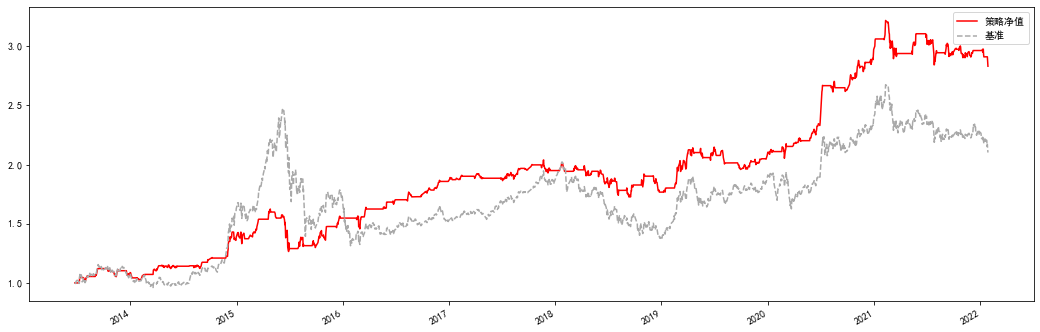

In [85]:
analysis_rets(bt_data['close'],bt_result.result)

,总交易次数,持仓最长时间(自然天),持仓最短时间(自然天),平均持仓天数(自然天),胜率(%),盈亏比
交易指标,86,69,1,16.94186,67.44%,2.3


d:\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




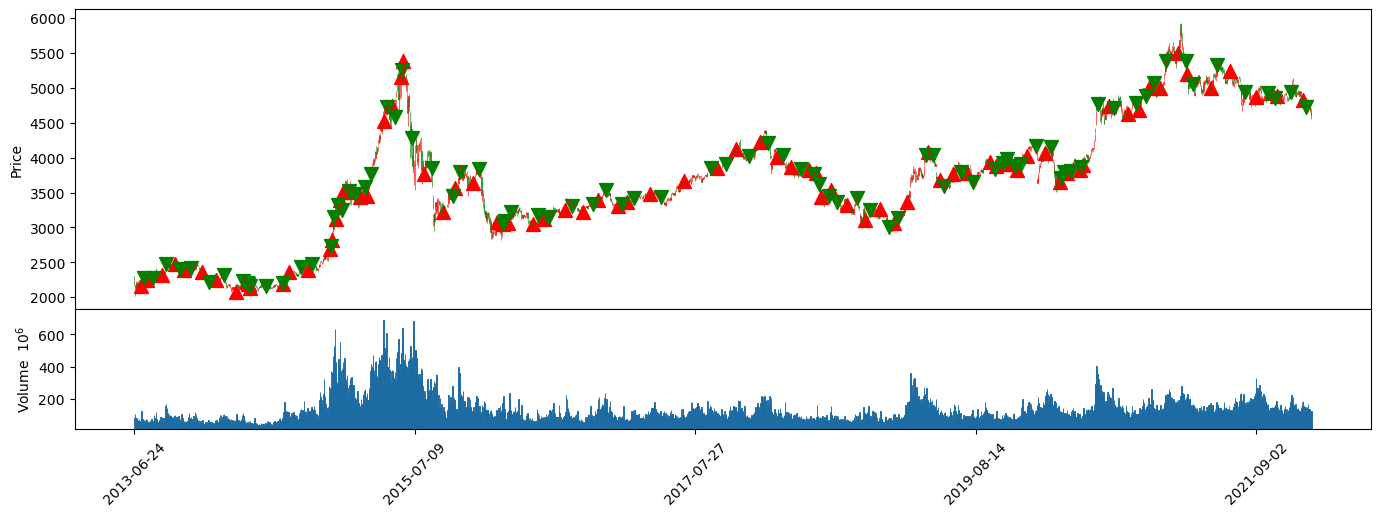

In [86]:
analysis_trade(bt_data,bt_result.result)

## 百分位

In [170]:



class quantile_bound_strategy(bt.Strategy):
    """百分位上下轨策略

    当下穿下轨时开仓,上穿上轨时平仓
    signal,ub,lb提前加载到数据中
    """

    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:
        # print('signal', self.data0.lines.signal)
        # 开仓信号
        # if上穿则1,否则为-1
        self.open_signal = bt.indicators.CrossOver(self.data0.lines.lb,
                                                   self.data0.lines.signal)
        # 平仓信号
        self.close_signal = bt.indicators.CrossOver(self.data0.lines.signal,
                                                    self.data0.lines.ub)

        self.order = None

    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 检查是否有持仓
        if not self.position:
            # vix下穿下轨,买入
            if self.open_signal > 0:
                # 全仓买入
                self.order = self.order_target_percent(target=0.9)
        # vix上穿上轨,卖出
        elif self.close_signal < 0:
            # 平仓
            self.order = self.close()

    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [171]:
bt_data1:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data1.rename(columns={'vol':'volume'},inplace=True)
bt_data1['openinterest'] = 0
bt_data1 = pd.concat((bt_data1,quantile_indincator),axis=1).dropna()

In [172]:
bt_result = get_backtesting(bt_data1,'hs300',quantile_bound_strategy,add_quantile_data)

2013-04-16,BUY EXECUTED,ref:1156,Price:2419.7500,Size:36.00,Cost:87110.9982,Comm 0.0000,Stock:hs300
2013-04-19,SELL EXECUTED,ref:1157,Price:2469.7040,Size:-36.00,Cost:87110.9982,Comm 0.0000,Stock:hs300
2013-04-23,BUY EXECUTED,ref:1158,Price:2532.2010,Size:36.00,Cost:91159.2360,Comm 0.0000,Stock:hs300
2013-04-26,SELL EXECUTED,ref:1159,Price:2477.4762,Size:-36.00,Cost:91159.2360,Comm 0.0000,Stock:hs300
2013-05-14,BUY EXECUTED,ref:1160,Price:2526.1450,Size:35.00,Cost:88415.0750,Comm 0.0000,Stock:hs300
2013-05-21,SELL EXECUTED,ref:1161,Price:2607.1323,Size:-35.00,Cost:88415.0750,Comm 0.0000,Stock:hs300
2013-07-11,BUY EXECUTED,ref:1162,Price:2232.3802,Size:41.00,Cost:91527.5888,Comm 0.0000,Stock:hs300
2013-08-08,SELL EXECUTED,ref:1163,Price:2277.0253,Size:-41.00,Cost:91527.5888,Comm 0.0000,Stock:hs300
2013-08-21,BUY EXECUTED,ref:1164,Price:2320.8161,Size:40.00,Cost:92832.6423,Comm 0.0000,Stock:hs300
2013-09-06,SELL EXECUTED,ref:1165,Price:2336.5333,Size:-40.00,Cost:92832.6423,Comm 0.0000,St

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,3.58%,34.60%,14.95%,31.03%,-31.46%,43.32%,11.38%
基准,8.54%,99.83%,22.91%,47.32%,-46.70%,64.86%,18.29%


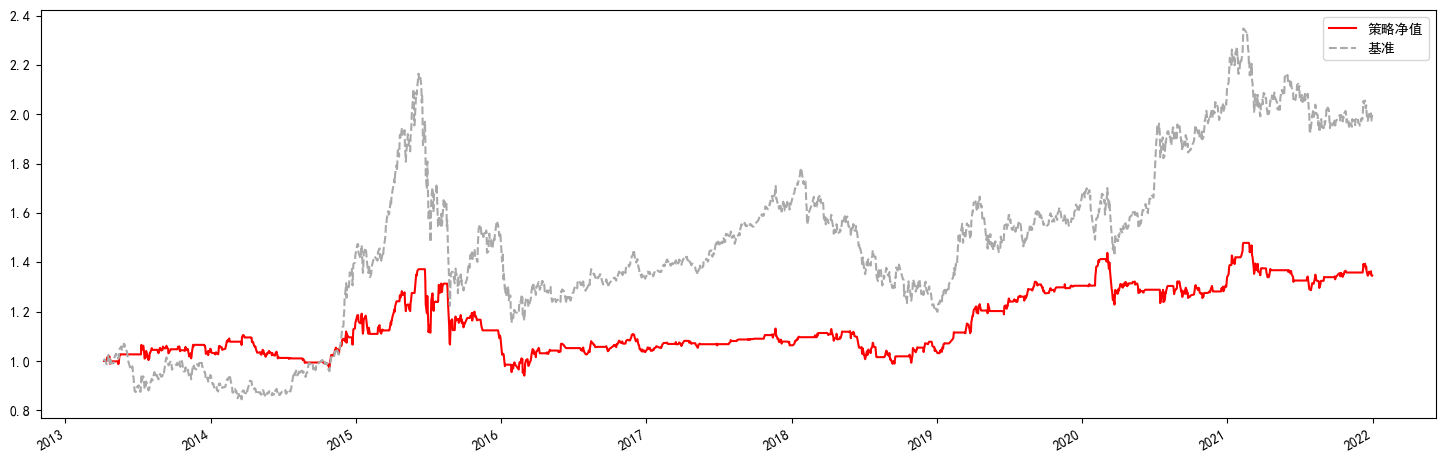

In [173]:
analysis_rets(bt_data1['close'],bt_result.result)